---
title: "Statistical Rethinking"
subtitle: "Week 2"
author: "Jakob Hoffmann"
date: "01/27/2023"
format: html
jupyter: julia-1.8
---

In [1]:
using HTTP
using CSV
using DataFrames
using DataFramesMeta
using CairoMakie
using Distributions

In [2]:
function download_data(dataset)
    repo = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/"
    link = repo * dataset
    file = HTTP.download(link)
    CSV.read(file, DataFrame)
end

download_data (generic function with 1 method)

In [4]:
df = download_data("Howell1.csv")

┌ Warning: Reading one byte at a time from HTTP.Stream is inefficient.
│ Use: io = BufferedInputStream(http::HTTP.Stream) instead.
│ See: https://github.com/BioJulia/BufferedStreams.jl
└ @ HTTP.Streams C:\Users\Jakob\.julia\packages\HTTP\z8l0i\src\Streams.jl:240
┌ Info: Downloading
│   source = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
│   dest = "C:\\Users\\Jakob\\AppData\\Local\\Temp\\Howell1.csv"
│   progress = NaN
│   time_taken = "0.03 s"
│   time_remaining = "NaN s"
│   average_speed = "372.467 KiB/s"
│   downloaded = "11.919 KiB"
│   remaining = "∞ B"
└   total = "∞ B"


Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


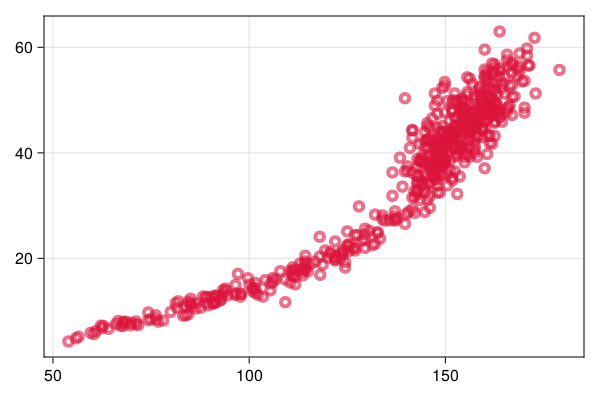

In [6]:
plotargs = (color=(:black, 0.0), strokewidth=4, strokecolor=(:crimson, .6),)
scatter(df.height, df.weight; figure=(;resolution=(600, 400)), plotargs...)

In [7]:
data = @rsubset df :age < 13

Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,121.92,19.6179,12.0,1
2,105.41,13.948,8.0,0
3,86.36,10.4893,6.5,0
4,109.22,15.9891,7.0,0
5,114.3,17.8602,11.0,1
6,121.92,20.4116,8.0,1
7,128.905,23.36,12.0,0
8,97.79,13.2676,5.0,0
9,110.49,15.4221,9.0,0


In [12]:
function simulate_data(age, β_age, β_height, β_age_height)
    μ_height = 30 + β_age_height*age
    height = rand(Normal(μ_height, 10))

    μ_weight = 5 + β_age*age + β_height*height
    weight = rand(Normal(μ_weight, 5))

    height, weight
end

simulate_data (generic function with 1 method)

In [13]:
age = 0:0.1:10
sim = simulate_data.(age, .3, .3, 15)
heights = first.(sim)
weights = last.(sim);

In [14]:
function plot_simulation(age, height, weight)
    fig = Figure(resolution=(800, 400))
    ax1 = Axis(fig[1,1]; xlabel="age", ylabel="height")
    ax2 = Axis(fig[1,2]; xlabel="age", ylabel="weight")
    scatter!(ax1, age, height; plotargs...)
    scatter!(ax2, age, weight; plotargs...)
    fig
end

plot_simulation (generic function with 1 method)

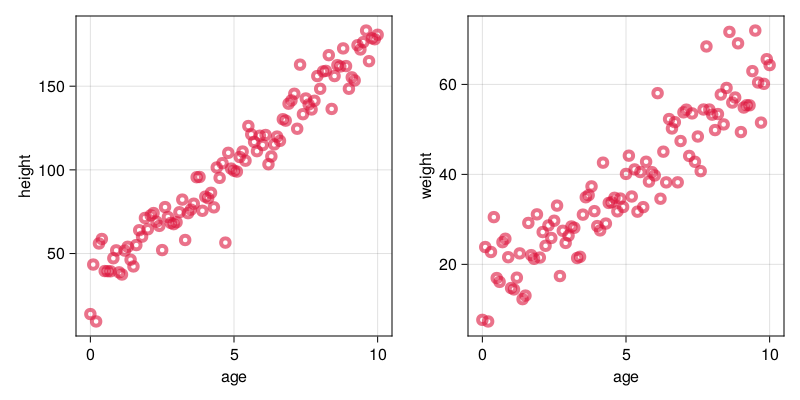

In [15]:
plot_simulation(age, heights, weights)

In [16]:
using Turing
using Optim
using StatsBase
using LinearAlgebra

In [17]:
@model function linear_regression(y, X)
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    σ ~ Exponential(1)
    μ = α .+ X*β
    for i in 1:size(X, 1)
        y[i] ~ Normal(μ[i], σ)
    end
end

linear_regression (generic function with 2 methods)

In [18]:
X = hcat(age, heights)
model = linear_regression(weights, X)

DynamicPPL.Model{typeof(linear_regression), (:y, :X), (), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{}, DynamicPPL.DefaultContext}(linear_regression, (y = [7.66275044499829, 23.850314205562437, 7.305756353394361, 22.741393878480714, 30.498673481468973, 16.957437488306876, 16.10423498811079, 24.92955543385712, 25.688770140315377, 21.585307780116484  …  54.85474606911841, 55.369291429917986, 55.34849004359123, 62.948120408602264, 71.96933805631511, 60.41319696478628, 51.508591957962544, 60.12374859877285, 65.60274622492987, 64.28905941201117], X = [0.0 13.836257046370793; 0.1 43.428424409065904; … ; 9.9 178.05082139647732; 10.0 180.72384469230295]), NamedTuple(), DynamicPPL.DefaultContext())

In [19]:
function quadratic_approximation(model)
    est = optimize(model, MAP())
    cov = Symmetric(vcov(est).array)
    MvNormal(est.values.array, cov)
end

quadratic_approximation (generic function with 1 method)

In [20]:
fit = quadratic_approximation(model)

FullNormal(
dim: 3
μ: [13.718233423427208, 4.906505524418857, 5.829630536233334]
Σ: [1.3089202488282212 -0.19534008419958596 -0.009029153039807293; -0.19534008419958596 0.039195288452061355 0.0013213129099367282; -0.009029153039807293 0.0013213129099367282 0.15489748796420602]
)


In [31]:
rand(fit, 1000)

3×1000 Matrix{Float64}:
 11.8867   13.1237   13.9369   12.7573   …  10.2734   13.1623   11.9923
  5.22257   4.88955   4.82269   4.92668      5.41446   4.67407   5.11668
  4.89582   5.17649   5.50547   5.99822      6.00476   5.51364   4.84485